In [6]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

In [7]:
from typing import Any
import usbtmc
import numpy as np
import time

class Oscilloscope(usbtmc.Instrument):
    def __init__(self, vendor_id=0x0957, product_id=0x900d, timeout=2):
        """
        Initialize the oscilloscope instrument.

        :param vendor_id: The vendor ID of the oscilloscope.
        :param product_id: The product ID of the oscilloscope.
        :param timeout: Communication timeout in seconds.
        """
        super().__init__(vendor_id, product_id)
        self.timeout = timeout
        self.write('*CLS')  # Clear the status
        self.write(':system:header off')
        self.write(':waveform:streaming ON')  # Enable waveform streaming
        self.write(':waveform:byteorder lsbfirst')
        self.write(':waveform:format word')  # Set waveform format to 16-bit word

    def __getattr__(self, name: str) -> Any:
        # specific procedures to do before returning variable
        match name:
            case 'instrument_name':
                return self.ask('*IDN?')
            case 'analog_sample_rate':
                return float(self.ask(':acquire:srate:analog?'))
            case 'digital_sample_rate':
                return float(self.ask(':acquire:srate:digital?'))
            case 'triggered':
                return bool(int(self.ask(':TER?')))

    def fetch_x_data(self):
        """
        Fetch X-axis data (time data) from the oscilloscope.

        :return: Numpy array of X-axis data (time points).
        """
        x_increment = float(self.ask(":WAV:XINC?"))
        x_origin = float(self.ask(":WAV:XOR?"))
        x_reference = float(self.ask(":WAV:XREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Generate the time (X-axis) data array
        x_data = np.arange(num_points) * x_increment + x_origin - x_reference * x_increment
        return x_data

    def fetch_y_data(self, channel=1):
        """
        Fetch Y-axis data (voltage data) from the oscilloscope for a specified channel.

        :param channel: The channel number to fetch data from (default is 1).
        :return: Numpy array of Y-axis data (voltage points).
        """
        # Set the channel to read from
        self.write(f":WAV:SOUR CHAN{channel}")

        # Get Y data scaling parameters
        y_increment = float(self.ask(":WAV:YINC?"))
        y_origin = float(self.ask(":WAV:YOR?"))
        y_reference = float(self.ask(":WAV:YREF?"))

        # Get the number of points from the oscilloscope
        num_points = int(self.ask(":WAV:POIN?"))

        # Request the waveform data
        self.write(":WAV:DATA?")
        raw_data = self.read_raw()  # Read raw data

        # Process the raw data
        header_size = 2  # Standard header size for 16-bit word data
        data_size = len(raw_data) - header_size - 1
        if data_size != num_points * 2:  # 16-bit data means 2 bytes per point
            raise ValueError(f"Mismatch in data length: expected {num_points * 2}, got {data_size}")
        
        # Convert raw data to a numpy array of 16-bit unsigned integers
        y_data = np.frombuffer(raw_data[header_size:-1], dtype=np.int16)
        # y_data = np.frombuffer(raw_data, dtype=np.int16, header_size=2)

        # Scale the data to get the correct voltage values
        y_data = (y_data - y_reference) * y_increment + y_origin
        return y_data

# Example usage:
# osc = Oscilloscope(vendor_id=0x1234, product_id=0x5678)
# x_data = osc.fetch_x_data()
# y_data = osc.fetch_y_data(channel=1)
# osc.close()


In [8]:
from types import MethodType
from multiprocessing import Queue, Process, Event, Pipe


class OscilloscopeProcessManager(Process):
    def __init__(self) -> None:
        super().__init__()
        self.daemon = True
        self.task_queue = Queue()
        self.data_queue = Queue()

        self.parent_pipe, self.child_pipe = Pipe()

        self.pause_event = Event()
        self.pause_event.set()
        self.stop_event  = Event()

        self.oscilloscope=None
    
    def __getattr__(self, name: str) -> Any:
        self.parent_pipe.send(name)
        
        while not self.stop_event.is_set():
            if self.parent_pipe.poll():
                return self.parent_pipe.recv()
            time.sleep(.01)
        
        raise BrokenPipeError('Process is not running, attributes cannot be accesed!')
    
    def run(self):
        self.oscilloscope=Oscilloscope()
        while not self.stop_event.is_set():
            # Poll pipe to send __getattr__ values back
            if self.child_pipe.poll():
                attr_name=self.child_pipe.recv()
                if hasattr(self.oscilloscope, attr_name):
                    # Send the attribute value back to the parent process
                    attr=getattr(self.oscilloscope, attr_name)
                    if type(attr) == MethodType:
                        self.child_pipe.send(attr())
                    else:
                        self.child_pipe.send(attr)
                else:
                    self.child_pipe.send(None)
            # Perform misc task - like waiting
            elif not self.task_queue.empty():
                task = self.task_queue.get()
                task()
            # Perform data acquisition and put it on data_queue
            elif not self.pause_event.is_set() \
                    and self.oscilloscope.triggered:
                y=self.oscilloscope.fetch_y_data()
                self.data_queue.put(y)
                del y
            
            time.sleep(.01)
        self.oscilloscope.close()
    
    def pause(self):
        self.pause_event.set()
    
    def play(self):
        self.pause_event.clear()

    def stop(self):
        self.stop_event.set()
        self.join(timeout=2)

In [9]:
scope_manager=OscilloscopeProcessManager()
scope_manager.start()

In [10]:
scope_manager.pause()

In [11]:
scope_manager.play()

In [12]:
scope_manager.instrument_name

'Agilent Technologies,MSO9404A,MY50290118,04.20.0001'

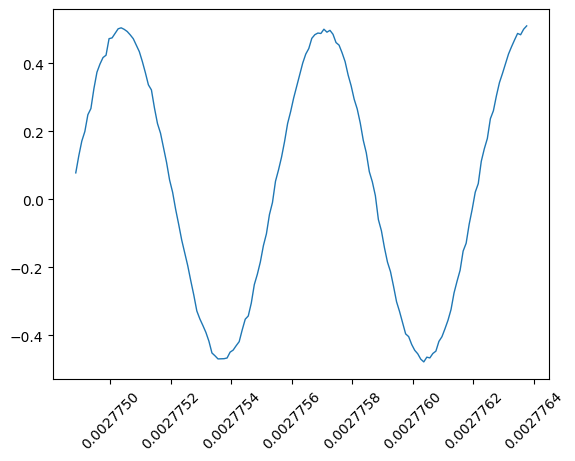

In [13]:
from IPython.display import clear_output

x=scope_manager.fetch_x_data
mid = len(x)//2

i = 0

while True:
    clear_output(wait=True)
    
    y=scope_manager.data_queue.get()

    plt.xticks(rotation=45)

    plot(x[mid:mid+150], y[mid:mid+150], lw=1)
    plt.show()

    i += 1
    if i == 10:
        break

In [14]:
scope_manager.data_queue.qsize()

0

In [15]:
scope_manager.stop()